In [ ]:
import json
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import utils
from keras.models import load_model  
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_hub as hub
import tokenization

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig

## 전처리

In [ ]:
with open(path + "train_data.json", 'r') as json_file:
    train_data = json.load(json_file)
    
with open(path + "dev_data.json", 'r') as json_file:
    dev_data = json.load(json_file)

In [ ]:
train_data[0]

{'profile': {'emotion': {'emotion-id': 'S09_D02_E37',
   'situation': ['S09', 'D02'],
   'type': 'E37'},
  'persona': {'computer': ['C01'],
   'human': ['A03', 'G02'],
   'persona-id': 'A03_G02_C01'},
  'persona-id': 'Pro_10888'},
 'talk': {'content': {'HS01': '기분이 좋지 않아',
   'HS02': '요새 건강검진을 받았는데 건강 상태가 좋지 않아.',
   'HS03': '이곳 저곳 관리해야 할 곳이 많아.',
   'SS01': '기분이 좋지 않은 이유를 알 수 있을까요?',
   'SS02': '많이 속상하시겠어요. 어디가 안 좋은가요?',
   'SS03': '안좋은 곳이 많아 걱정이 많으시겠어요.'},
  'id': {'profile-id': 'Pro_10888', 'talk-id': 'Pro_10888_00001'}}}

In [ ]:
train_data[0]['profile']['emotion']['type']

'E37'

In [ ]:
train_x = []
train_Y = []
order = ['HS01', 'SS01', 'HS02', 'SS02', 'HS03', 'SS03']
RE_FILTER = re.compile("[.,!?\':;~()]")

for i in range(len(train_data)):
    for j in order:     
        text = train_data[i]['talk']['content'][j]
        text = re.sub(RE_FILTER,  ""  , text)
        train_x.append(text)
        
for i in range(len(train_data)):
    train_Y.append(train_data[i]['profile']['emotion']['type'])

In [ ]:
len(train_data) * 6

94992

In [ ]:
len(train_data)

15832

In [ ]:
train_X = []

for i in range(0, 94991, 6):
    X = train_x[i] + ' ' + train_x[i+1] + ' ' + train_x[i+2] + ' ' + train_x[i+3] + ' ' + train_x[i+4] + ' ' + train_x[i+5]
    train_X.append(X)

In [ ]:
train_X[15831]

'요즘 몸 상태도 예전 같지 않고 살날이 얼마 남았을까 걱정이 돼 그러시군요 걱정이 되시겠어요 내가 죽는 건 별로 문제가 아니지만 나 없이 자식이 잘살지 걱정이 돼 죽음이 두려운 건 그런 까닭이야 자식을 사랑하는 마음이 크게 느껴져요  '

In [ ]:
encoder = LabelEncoder()

encoder = encoder.fit(train_Y)
train_Y = encoder.transform(train_Y)

In [ ]:
mapping = dict(zip( range(len(encoder.classes_)), encoder.classes_))
mapping

{0: 'E10',
 1: 'E11',
 2: 'E12',
 3: 'E13',
 4: 'E14',
 5: 'E15',
 6: 'E16',
 7: 'E17',
 8: 'E18',
 9: 'E19',
 10: 'E20',
 11: 'E21',
 12: 'E22',
 13: 'E23',
 14: 'E24',
 15: 'E25',
 16: 'E26',
 17: 'E27',
 18: 'E28',
 19: 'E29',
 20: 'E30',
 21: 'E31',
 22: 'E32',
 23: 'E33',
 24: 'E34',
 25: 'E35',
 26: 'E36',
 27: 'E37',
 28: 'E38',
 29: 'E39',
 30: 'E40',
 31: 'E41',
 32: 'E42',
 33: 'E43',
 34: 'E44',
 35: 'E45',
 36: 'E46',
 37: 'E47',
 38: 'E48',
 39: 'E49',
 40: 'E50',
 41: 'E51',
 42: 'E52',
 43: 'E53',
 44: 'E54',
 45: 'E55',
 46: 'E56',
 47: 'E57',
 48: 'E58',
 49: 'E59',
 50: 'E60',
 51: 'E61',
 52: 'E62',
 53: 'E63',
 54: 'E64',
 55: 'E65',
 56: 'E66',
 57: 'E67',
 58: 'E68',
 59: 'E69'}

In [ ]:
train_labels = utils.to_categorical(train_Y)

## Tensorflow Hub BERT

In [ ]:
def bert_encode(texts, tokenizer, max_len = 512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len = 512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(60, activation='softmax')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-6), loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [ ]:
# bert_en_uncased: 영어 소문자 / bert_en_cased: 영어 대소문자 / bert_multi_cased: 다국어
# L : transformer block의 layer 수
# H : hidden size
# A : self-attention heads 수
# feed-forward/filter size = 4H
module_url = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1'.
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1: 233.99MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1: 543.99MB
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1, Total size: 683.49MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1'.


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(train_X, tokenizer, max_len = 140)

In [ ]:
model = build_model(bert_layer, max_len = 140)
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 140)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 140)]        0                                            
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpoint = ModelCheckpoint('final_model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.3,
    epochs=50,
    callbacks=[earlystopping, checkpoint],
    batch_size=32)

Epoch 1/50
347/347 [==============================] - 138s 398ms/step - loss: 4.1679 - acc: 0.0183 - val_loss: 4.1774 - val_acc: 0.0154
Epoch 2/50
347/347 [==============================] - 135s 388ms/step - loss: 4.1024 - acc: 0.0217 - val_loss: 4.1583 - val_acc: 0.0131
Epoch 3/50
347/347 [==============================] - 138s 396ms/step - loss: 4.0824 - acc: 0.0282 - val_loss: 4.1568 - val_acc: 0.0103
Epoch 4/50
347/347 [==============================] - 134s 387ms/step - loss: 4.0504 - acc: 0.0393 - val_loss: 4.1325 - val_acc: 0.0177
Epoch 5/50
347/347 [==============================] - 137s 394ms/step - loss: 3.9811 - acc: 0.0559 - val_loss: 4.1107 - val_acc: 0.0278
Epoch 6/50
347/347 [==============================] - 136s 393ms/step - loss: 3.8237 - acc: 0.0867 - val_loss: 4.0497 - val_acc: 0.0436
Epoch 7/50
347/347 [==============================] - 136s 393ms/step - loss: 3.5920 - acc: 0.1430 - val_loss: 3.8733 - val_acc: 0.1128
Epoch 8/50
347/347 [============================

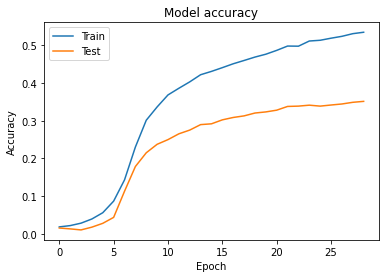

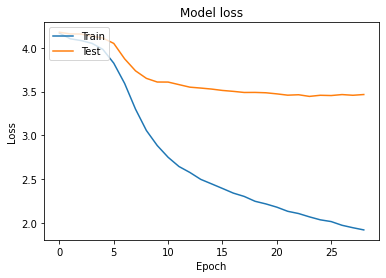

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
len(dev_data) * 6

10302

In [ ]:
dev_x = []
dev_Y = []
order = ['HS01', 'SS01', 'HS02', 'SS02', 'HS03', 'SS03']
RE_FILTER = re.compile("[.,!?\':;~()]")

for i in range(len(dev_data)):
    for j in order:     
        text = dev_data[i]['talk']['content'][j]
        text = re.sub(RE_FILTER,  ""  , text)
        dev_x.append(text)
        
for i in range(len(dev_data)):
    dev_Y.append(dev_data[i]['profile']['emotion']['type'])
    
dev_X = []

for i in range(0, 10301, 6):
    X = dev_x[i] + ' ' + dev_x[i+1] + ' ' + dev_x[i+2] + ' ' + dev_x[i+3] + ' ' + dev_x[i+4] + ' ' + dev_x[i+5]
    dev_X.append(X)

dev_Y = encoder.fit_transform(dev_Y)

In [ ]:
test_input = bert_encode(dev_X, tokenizer, max_len = 140)
test_labels = utils.to_categorical(dev_Y)

In [ ]:
loaded_model = load_model('final_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_input, test_labels)[1]))

54/54 [==============================] - 6s 102ms/step - loss: 2.7822 - acc: 0.4211

 테스트 정확도: 0.4211


In [ ]:
test_pred = model.predict(test_input)
mapping[np.where(test_pred[0] == test_pred[0].max())[0][0]]

'E39'

In [ ]:
test_pred[0].max()

0.14784212